In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [44]:
df = pd.read_csv('fairjob.csv')

In [45]:
df.shape

(1072226, 56)

In [46]:
def stratified_split_multi(df):
    np.random.seed(42)  # For reproducibility

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    val_data = pd.DataFrame()

    # Create a 'rank_category' column for stratification
    df = df.copy()  # Avoid modifying the original dataframe
    df['rank_category'] = df['rank'].apply(lambda x: 'above_10' if x > 10 else 'below_10')

    # Define the stratification columns
    stratify_cols = ['click', 'rank_category', 'protected_attribute']

    # Perform stratified splitting for each group
    for _, group_data in df.groupby(stratify_cols):
        shuffled = group_data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle within group

        total = len(shuffled)
        train_end = int(total * 0.9)  # 90% train
        test_end = int(total * 0.95)  # Next 5% test

        train_data = pd.concat([train_data, shuffled.iloc[:train_end]])
        test_data = pd.concat([test_data, shuffled.iloc[train_end:test_end]])
        val_data = pd.concat([val_data, shuffled.iloc[test_end:]])

    # Reset index for all splits
    train_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)
    val_data.reset_index(drop=True, inplace=True)

    # Drop the temporary 'rank_category' column
    for split in [train_data, test_data, val_data]:
        split.drop(columns=['rank_category'], inplace=True, errors='ignore')

    return train_data, test_data, val_data


In [47]:
train_data, test_data, dev_data = stratified_split_multi(df)

# Print the sizes
print(f"Train size: {len(train_data)}")
print(f"Dev size: {len(dev_data)}")
print(f"Test size: {len(test_data)}")

Train size: 965000
Dev size: 53614
Test size: 53612


In [48]:
train_data.columns

Index(['click', 'protected_attribute', 'senior', 'displayrandom', 'rank',
       'user_id', 'impression_id', 'product_id', 'cat0', 'cat1', 'cat2',
       'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10',
       'cat11', 'cat12', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21',
       'num22', 'num23', 'num24', 'num25', 'num26', 'num27', 'num28', 'num29',
       'num30', 'num31', 'num32', 'num33', 'num34', 'num35', 'num36', 'num37',
       'num38', 'num39', 'num40', 'num41', 'num42', 'num43', 'num44', 'num45',
       'num46', 'num47', 'num48', 'num49', 'num50'],
      dtype='object')

### PCA Code

In [49]:
def pca_with_variance(df, max_dimensions=None):
    # 1. Centering the data
    data = df.values
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    
    # 2. Computing the covariance matrix and its eigenvalues and vectors
    cov_mat = np.cov(centered_data, rowvar=False)
    evals, evecs = np.linalg.eigh(cov_mat)

    # 3. Sorting eigenvalues and eigenvectors
    indices = np.argsort(evals)[::-1]
    evals_sorted = evals[indices]
    evecs_sorted = evecs[:, indices]

    # 4. Calculate explained variance ratio
    total_variance = np.sum(evals_sorted)
    explained_variance_ratio = evals_sorted / total_variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Determine max dimensions to retain
    if max_dimensions is None or max_dimensions > len(evals_sorted):
        max_dimensions = len(evals_sorted)

    # 5. Select eigenvectors for top k dimensions
    selected_evecs = evecs_sorted[:, :max_dimensions]
    data_projected = np.dot(centered_data, selected_evecs)
    
    return (pd.DataFrame(data_projected, columns=[f'PC{i+1}' for i in range(max_dimensions)]),
            explained_variance_ratio, cumulative_variance)


In [50]:
def pca(df, dimention):
    # 1. Centering the data
    data = df.values
    mean = np.mean(data, axis=0)
    centered_data = data-mean
    
    # 2. Computing the coveranice matrix and its eigen values and vectors
    cov_mat = np.cov(centered_data, rowvar=False)
    evals, evecs = np.linalg.eigh(cov_mat)

    # 3. Sorting eigen values
    indices = np.argsort(evals)[::-1]
    evals_sorted = evals[indices]
    evecs_sorted = evecs[:, indices]

    # 4. Selecting top k dimention according to input
    selected_evecs = evecs_sorted[:, :dimention]

    # 5. Project into calculated direction
    data_projected = np.dot(centered_data, selected_evecs)

    # 6. Sending the df
    df_final = pd.DataFrame(data_projected, columns=[f'PC{i+1}' for i in range(dimention)])
    return df_final

### Performing PCA on CAT and NUM columns

In [51]:
# Step 1: Extract the features for PCA
user_categorical_features = [f'cat{i}' for i in range(0, 6)]
product_categorical_features = [f'cat{i}' for i in range(6, 13)]
numerical_features = [f'num{i}' for i in range(16, 51)]

# Separate the categorical and numerical data
user_cat_data = train_data[user_categorical_features]
product_cat_data = train_data[product_categorical_features]
num_data = train_data[numerical_features]

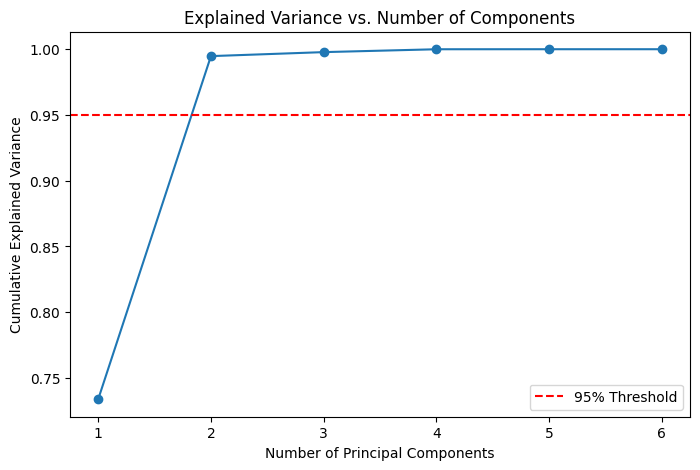

Optimal number of components for 95% variance: 2


In [52]:
# Apply PCA to your data
cat_pca_result, explained_variance_ratio, cumulative_variance = pca_with_variance(user_cat_data)

# Plot cumulative variance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()

# Find the minimum number of components for 95% variance
optimal_k = next(i for i, cumulative_var in enumerate(cumulative_variance, 1) if cumulative_var >= 0.95)
print(f"Optimal number of components for 95% variance: {optimal_k}")

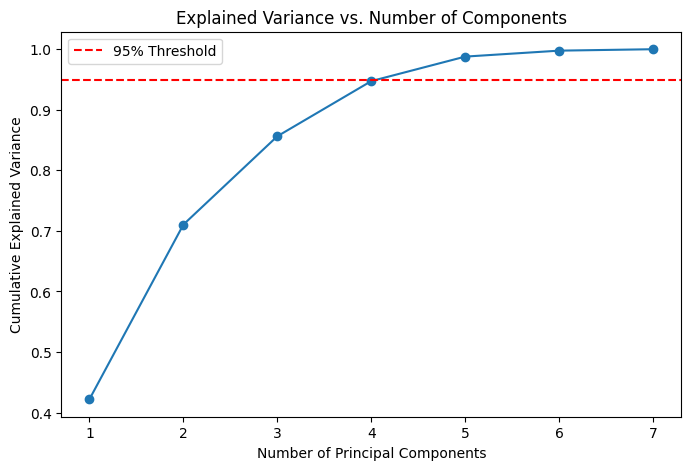

Optimal number of components for 95% variance: 5


In [53]:
# Apply PCA to your data
cat_pca_result, explained_variance_ratio, cumulative_variance = pca_with_variance(product_cat_data)

# Plot cumulative variance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()

# Find the minimum number of components for 95% variance
optimal_k = next(i for i, cumulative_var in enumerate(cumulative_variance, 1) if cumulative_var >= 0.95)
print(f"Optimal number of components for 95% variance: {optimal_k}")


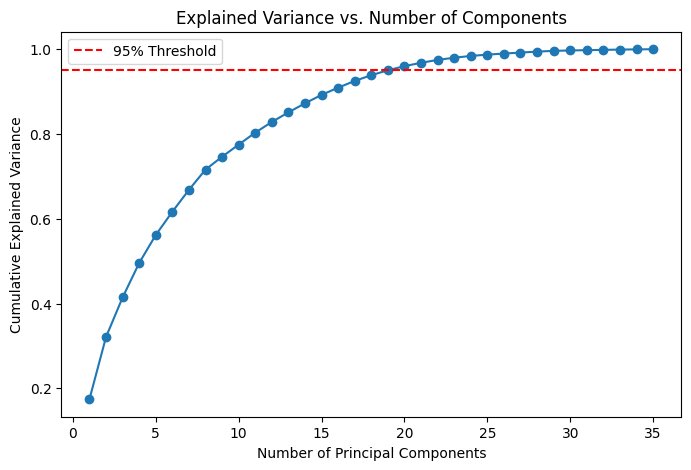

Optimal number of components for 95% variance: 19


In [54]:
# Apply PCA to your data
num_pca_result, explained_variance_ratio, cumulative_variance = pca_with_variance(num_data)

# Plot cumulative variance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()

# Find the minimum number of components for 95% variance
optimal_k = next(i for i, cumulative_var in enumerate(cumulative_variance, 1) if cumulative_var >= 0.95)
print(f"Optimal number of components for 95% variance: {optimal_k}")


### Function to apply PCA and merge it with original dataset

In [55]:
def apply_pca_and_merge(df):
    
    # Dimensions for PCA
    user_cat_dim = 2
    product_cat_dim = 5
    num_dim = 19
    
    # Extract feature groups
    user_cat_data = df[user_categorical_features]
    product_cat_data = df[product_categorical_features]
    num_data = df[numerical_features]
    
    # Apply PCA for user categorical features
    user_cat_pca_result = pca(user_cat_data, dimention=user_cat_dim)
    user_cat_pca_result.columns = [f'user_cat_PC{i+1}' for i in range(user_cat_pca_result.shape[1])]
    
    # Apply PCA for product categorical features 
    product_cat_pca_result = pca(product_cat_data, dimention=product_cat_dim)
    product_cat_pca_result.columns = [f'product_cat_PC{i+1}' for i in range(product_cat_pca_result.shape[1])]
    
    # Apply PCA for numerical features
    num_pca_result = pca(num_data, dimention=num_dim)
    num_pca_result.columns = [f'num_PC{i+1}' for i in range(num_pca_result.shape[1])]
    
    # Merge PCA results with the original dataframe
    pca_results = pd.concat([user_cat_pca_result, product_cat_pca_result, num_pca_result], axis=1)
    df_pca = pd.concat([df.reset_index(drop=True), pca_results], axis=1)
    
    # Drop original categorical and numerical columns
    columns_to_drop = user_categorical_features + product_categorical_features + numerical_features
    df_pca.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    return df_pca


### On Train Data

In [56]:
train_data_pca = apply_pca_and_merge(train_data)

In [57]:
train_data_pca

,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,user_cat_PC1,user_cat_PC2,...,num_PC10,num_PC11,num_PC12,num_PC13,num_PC14,num_PC15,num_PC16,num_PC17,num_PC18,num_PC19
0,0,0,0,0,13,2607,227077,23118,257.662758,14.710393,...,-0.437708,0.589223,-0.046386,-0.321518,0.040128,-0.062750,-0.268792,-0.022069,0.017010,0.137350
1,0,0,1,0,14,7404,99336,14985,277.738515,270.944092,...,1.331259,-0.174154,-0.686685,-0.339030,-0.924905,-0.310639,-1.567150,-0.758810,0.230582,0.062501
2,0,0,0,0,17,18272,77367,38402,-40.915187,-160.610009,...,0.568764,0.104379,0.251375,0.018795,-0.234892,-0.537174,0.087878,-0.190188,0.038254,0.188169
3,0,0,0,0,18,16827,71391,3539,-233.266286,266.794334,...,0.635345,0.186269,-0.373932,-1.550075,-0.910459,-0.488419,0.033545,-0.281552,0.171289,0.588787
4,0,0,0,0,16,30676,231043,21503,-200.265055,391.075932,...,2.039493,-0.277977,-1.890698,0.181908,-0.273735,-0.100833,-0.354270,-0.137752,0.159043,-0.070355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964995,1,1,1,0,1,11816,242213,41653,-532.366494,273.405811,...,-0.548566,0.233733,1.371371,-1.493668,-1.136163,-1.067378,0.503754,1.094687,-0.183531,1.628474
964996,1,1,1,0,1,29587,197180,55131,-533.805890,482.887982,...,0.703075,0.180058,-0.234249,-0.295102,-0.343120,-0.217394,-0.018295,-0.133517,0.125169,0.027965
964997,1,1,1,0,5,22277,36294,25682,711.896590,122.341066,...,0.434598,-0.160279,1.280929,-0.005241,-0.074370,0.100472,0.873301,-1.773949,0.047171,1.004267
964998,1,1,1,0,1,17501,159374,28020,104.243753,475.696199,...,0.651391,0.172995,-0.066376,-0.263161,-0.338796,-0.245407,-0.050941,-0.118884,0.118319,0.056023


### On Dev Data

In [58]:
dev_data_pca = apply_pca_and_merge(dev_data)

In [59]:
dev_data_pca

,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,user_cat_PC1,user_cat_PC2,...,num_PC10,num_PC11,num_PC12,num_PC13,num_PC14,num_PC15,num_PC16,num_PC17,num_PC18,num_PC19
0,0,0,1,0,13,4275,10097,4696,714.674245,285.231780,...,-0.427994,-0.436731,0.239544,-0.040349,0.341440,0.524381,-0.145425,0.149053,0.066727,-0.110346
1,0,0,0,0,13,20520,215176,34002,598.239678,-215.861488,...,-0.154779,-0.047987,-0.892360,-0.894968,-0.305107,0.091237,0.253884,-0.147178,0.143557,-0.289484
2,0,0,0,0,18,31269,123470,2232,-201.225621,-371.683275,...,-0.646597,-0.477130,-0.183139,0.244123,0.368178,0.253625,-0.087670,-0.171178,0.136322,-0.091719
3,0,0,1,0,18,12800,233929,55033,711.517201,-71.690942,...,-0.477675,-0.340904,-0.017749,-0.391604,0.403709,0.001539,0.473710,-0.005929,0.167492,0.179721
4,0,0,1,0,16,1507,155476,3067,709.535582,-295.854852,...,-0.465315,-0.438349,-0.564636,-0.208948,0.081455,0.594684,-0.113406,-0.233231,0.169591,0.001015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53609,1,1,1,1,1,18114,71241,11354,-528.950071,220.189839,...,-1.102887,-1.535911,-0.352973,0.304198,0.892104,0.215062,-0.205780,-0.174253,0.208123,-0.053506
53610,1,1,0,0,1,18652,168196,59440,378.419629,32.174312,...,0.038822,0.721426,-0.005106,-0.412095,-0.466958,0.658794,0.008128,-0.131541,0.069586,0.070148
53611,1,1,1,0,6,17219,163014,4696,714.675749,285.231920,...,-0.001196,0.863852,0.330097,0.152926,-0.148035,0.183441,0.043234,-0.212120,0.039055,-0.066458
53612,1,1,1,0,1,10346,41010,48496,-530.857505,0.226734,...,0.208311,0.628444,-0.109762,-1.350646,-0.912644,0.898822,0.087432,-0.338196,0.050831,0.038347


### On Test Data

In [60]:
test_data_pce = apply_pca_and_merge(test_data)

In [61]:
test_data_pce

,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,user_cat_PC1,user_cat_PC2,...,num_PC10,num_PC11,num_PC12,num_PC13,num_PC14,num_PC15,num_PC16,num_PC17,num_PC18,num_PC19
0,0,0,1,0,11,9000,135814,45576,-531.580172,-99.464862,...,1.627386,0.447377,-0.479708,3.017110,0.599136,0.622459,0.264283,0.375019,0.353662,-0.166440
1,0,0,1,0,15,12991,93154,48208,-531.110480,-158.352678,...,-0.639992,-0.469003,0.408737,0.404283,-0.333757,-0.794732,-0.232292,0.543848,-0.021287,-0.043884
2,0,0,0,0,12,29046,230023,22439,10.425063,36.340754,...,0.892474,-0.011204,-0.215543,-0.402644,0.146616,0.142888,-1.596722,0.315826,-0.113374,0.136068
3,0,0,1,0,21,9523,37543,8851,-533.211107,102.764966,...,-2.118954,-0.677447,1.160966,-1.721854,-0.778295,0.488041,-0.114534,-0.431220,-3.713680,-1.033022
4,0,0,0,0,29,27365,86652,40999,376.269419,58.234772,...,0.505758,-0.217253,-1.053233,-0.249584,-0.175317,0.169555,-0.263369,0.434872,-0.290336,0.489692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53607,1,1,1,0,7,6901,102778,16336,712.215782,-182.052200,...,0.087454,-0.422515,0.066892,0.567408,-0.915076,-0.537532,-0.249075,0.109222,0.112817,-0.062299
53608,1,1,1,0,1,22564,170501,55131,-536.150275,482.009265,...,-0.725127,0.260371,0.256388,0.382352,-0.353233,-0.451527,-0.159515,-0.132000,-0.039763,-0.013740
53609,1,1,0,0,1,6884,41171,36549,-44.466978,16.624422,...,0.895699,0.009706,0.598950,-0.360347,0.603265,-0.133035,-0.028433,-1.093566,-0.285756,0.599336
53610,1,1,1,0,1,28560,108228,12469,707.564634,383.819727,...,0.719921,-0.210327,0.001252,-0.061592,-0.158994,0.198474,-0.046842,-0.294391,-0.130688,0.102840
